## Loading packages <a class="anchor" id="Loading_packages"></a>

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100
from datetime import date
today = str(date.today())
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'pdf')

sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2
import os
os.getcwd()

Global seed set to 0
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Running Scanpy 1.9.1, on 2023-06-02 21:33.


'/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/Latest_version'

First, let's define where we save the results of our analysis:

In [2]:
results_folder = '/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v10_paed_CITE_v4v5'
# os.mkdir(results_folder)
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Loading scRNA-seq reference data <a class="anchor" id="Loading_Visium"></a>

In [3]:
adata_ref_all = sc.read('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/Latest_version/HSTA_paed_v21.h5ad')
adata_ref_all.X = adata_ref_all.layers['counts']
del adata_ref_all.layers['counts']

In [4]:
adata_ref = adata_ref_all[adata_ref_all.obs['age_group'] != 'fetal', :].copy()

In [5]:
adata_ref.obs['study'].value_counts()

SpatialAtlas-Taghon       159813
Park2020                  104471
SpatialAtlas-Teichmann     69296
Bautista2021                7754
Campinoti2020               4275
Name: study, dtype: int64

In [6]:
adata_ref = adata_ref[adata_ref.obs['annotation_level_0'].isin(['APC','stroma','blood']) | adata_ref.obs['study'].isin(['SpatialAtlas-Taghon'])]
adata_ref

View of AnnData object with n_obs × n_vars = 189494 × 36751
    obs: 'n_genes', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_

In [7]:
adata_ref.obs['study'].value_counts()

SpatialAtlas-Taghon       159813
SpatialAtlas-Teichmann     14284
Bautista2021                7343
Park2020                    4099
Campinoti2020               3955
Name: study, dtype: int64

In [8]:
newanno = pd.read_csv('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/Latest_version/HTA2_CITEseq_reanno_CD4immature.csv')
newanno

,Unnamed: 0,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,barcode,n_genes,sample_barcode,batch,chemistry,age_group,age_numeric,sampleID_TCRab,path_TCRab,type,study,sample,enrichment,doublet_score,predicted_doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,percent_mt2,n_counts,barcode_sequence,louvian_1,louvian_05,latent_cell_probability,latent_RT_efficiency,log1p_n_counts,log1p_n_genes,percent_mito,n_counts_mito,percent_ribo,n_counts_ribo,percent_hb,n_counts_hb,percent_top50,n_counts_raw,log1p_n_counts_raw,n_genes_raw,log1p_n_genes_raw,percent_mito_raw,n_counts_mito_raw,percent_ribo_raw,n_counts_ribo_raw,percent_hb_raw,n_counts_hb_raw,percent_top50_raw,n_counts_spliced,log1p_n_counts_spliced,n_genes_spliced,log1p_n_genes_spliced,percent_mito_spliced,n_counts_mito_spliced,percent_ribo_spliced,n_counts_ribo_spliced,percent_hb_spliced,n_counts_hb_spliced,percent_top50_spliced,n_counts_unspliced,log1p_n_counts_unspliced,n_genes_unspliced,log1p_n_genes_unspliced,percent_mito_unspliced,n_counts_mito_unspliced,percent_ribo_unspliced,n_counts_ribo_unspliced,percent_hb_unspliced,n_counts_hb_unspliced,percent_top50_unspliced,percent_soup,percent_spliced,scrublet_score,scrublet_score_z,cluster_scrublet_score,bh_pval,scrublet_done,ctp_pred,ctp_pred_prob,ctp_pred_uncertain,qc_cluster,pass_auto_filter_mito20,good_qc_cluster_mito20,pass_default,mapping_anno_v2,Enzyme,Med_nFeature,Sample,SampleID_BCR,SampleID_TCRab,SampleID_TCRgd,sub_clusters,mapping_anno_v3,mapping_anno_v4,annotation_level_0,chemistry_simple,level_CD25,level_CD45RA,level_FOXP3,level_CD39,level_CD69,CITE_anno_v1,louvain_6,louvain_10,pct_counts_ribo.1,mapping_anno_v3_clean,louvain_20,Study_group,louvain_1,louvain_03,keep_0,backup_barcode,orig.ident,samples,ID,DOB,age_days,age_months,sex,percent.mt,percent.rb,T_Lineage_level_1,donor,validated_doublet,annotation_level_4,annotation_level_1,annotation_level_2,leiden_05,leiden_1,louvain_2,leiden_2,louvain_3,annotation_level_3,cite_w_protein,has_contig,clone_id,clone_id_by_size,locus_VDJ,locus_VJ,productive_VDJ,productive_VJ,v_call_VDJ,d_call_VDJ,j_call_VDJ,v_call_VJ,j_call_VJ,c_call_VDJ,c_call_VJ,junction_VDJ,junction_VJ,junction_aa_VDJ,junction_aa_VJ,v_call_abT_VDJ,d_call_abT_VDJ,j_call_abT_VDJ,v_call_abT_VJ,j_call_abT_VJ,c_call_abT_VDJ,c_call_abT_VJ,productive_abT_VDJ,productive_abT_VJ,duplicate_count_abT_VDJ,duplicate_count_abT_VJ,v_call_VDJ_main,v_call_VJ_main,d_call_VDJ_main,j_call_VDJ_main,j_call_VJ_main,c_call_VDJ_main,c_call_VJ_main,v_call_abT_VDJ_main,d_call_abT_VDJ_main,j_call_abT_VDJ_main,v_call_abT_VJ_main,j_call_abT_VJ_main,isotype,isotype_status,locus_status,chain_status,rearrangement_status_VDJ,rearrangement_status_VJ,nhood_ixs_random,nhood_ixs_refined,nhood_kth_distance,pseudotime_nhood_vdj,pred_pseudotime_nhood_vdj,anno_pseudotime_bin,vdj_pseudotime_bin,prob_T_CD8_nhood_vdj,prob_T_CD4_nhood_vdj,prob_T_CD8_nhood_vdj_bin,pred_prob_T_CD8_nhood_vdj,pred_prob_T_CD4_nhood_vdj,s_score,g2m_Score,cc_phase,v_call_gdT_VDJ,j_call_gdT_VDJ,v_call_gdT_VJ,j_call_gdT_VJ,c_call_gdT_VDJ,c_call_gdT_VJ,productive_gdT_VDJ,productive_gdT_VJ,v_call_gdT_VDJ_main,j_call_gdT_VDJ_main,v_call_gdT_VJ_main,j_call_gdT_VJ_main,RNA.weight,ADTdsb.weight,wsnn_res.0.5,seurat_clusters,wnn_clust_l1,anno_CITE_1,anno_CITE_2,anno_CITE_3,anno_CITE_4,levels_CD99,anno_CITE_4v2,anno_CITE_1v2,anno_CITE_2v2,anno_CITE_3v2,anno_CITE_4v3,dpt_spca_immature,dpt_rank_spca_immature,dpt_rna_DP,dpt_rank_rna_DP,spt_rna_DP_main,spt_rna_DP_CD99late,spt_rna_DP_CD99early,spt_rna_DP_HSPH1,spt_spca_SP_Treg,spt_spca_SP_CD8aa,spt_spca_SP_CD4,spt_spca_SP_CD8,spt_spca_SP_TregCD8,anno_CITE_4v4,anno_CITE_4v5
0,GEX1-TTCTACACAGTGACAG,12512,141,1715.415044,5958,GEX1-TTCTACACAGTGACAG,5958,sample1-TTCTACACAGTGACAG,141,5'v2,infant,2,NaN,NaN,cells,SpatialAtlas-Taghon,sample1,CD3N,0.063751,False,5958,31263,399,1.276269,7685,24.581774,1,0.003199,0.012763,32378.7130,TTCTACACAGTGACAG,5,2,NaN,NaN,NaN,NaN,NaN,NaN

In [9]:
adata_ref.obs['anno_CITE_4v5'] = adata_ref.obs['anno_CITE_4v3'].astype('object')
newanno = newanno[newanno['anno_CITE_4v5'] != 'DP(Q)_rearr']
adata_ref.obs['anno_CITE_4v5'].loc[newanno['sample_barcode']] = np.array(newanno['anno_CITE_4v5'] )
adata_ref.obs['anno_CITE_4v5'] = adata_ref.obs['anno_CITE_4v5'].astype('category')

adata_ref.obs['anno_CITE_4v4'] = adata_ref.obs['anno_CITE_4v3'].astype('object')
newanno = newanno[newanno['anno_CITE_4v4'] != 'DP(Q)_rearr']
adata_ref.obs['anno_CITE_4v4'].loc[newanno['sample_barcode']] = np.array(newanno['anno_CITE_4v4'] )
adata_ref.obs['anno_CITE_4v4'] = adata_ref.obs['anno_CITE_4v4'].astype('category')


/tmp/ipykernel_3074/3903937281.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ref.obs['anno_CITE_4v5'] = adata_ref.obs['anno_CITE_4v3'].astype('object')
/tmp/ipykernel_3074/3903937281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_ref.obs['anno_CITE_4v5'].loc[newanno['sample_barcode']] = np.array(newanno['anno_CITE_4v5'] )
/tmp/ipykernel_3074/3903937281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_ref.obs['anno_CITE_4v4'].loc[newanno['sample_barcode']] = np.array(newanno['anno_CITE_4v4'] )


In [10]:
anno = 'anno_CITE_4v5'
adata_ref.obs[anno].value_counts()

DP(Q)_rearr            45276
nan                    30957
DP(P)_early            22837
DP_4hi8lo              12206
committed_CD4pos        6497
DP_pos_sel              6186
SP_CD4_semimature       5499
SP_CD4_immature         4683
SP_CD8_semimature       4496
committed_CD4neg        3846
DP_early_CD31           3021
mTECI                   2885
mcTEC                   2767
cTECIII                 2157
SP_Treg_mature          2119
SP_CD8_immature         2032
cTECI                   1968
SP_Treg_immature        1658
EC-Ven                  1657
SMC                     1621
cTECII                  1590
PeriloFb                1338
InterloFb               1259
TEC-neuro               1238
B                        975
EC-Art                   876
CD8aaI_immature          827
mTECII                   794
mTECIII                  745
SP_CD4_mature            714
CD8aaII_mature           712
B_memory                 694
CD8aaII_immature         646
Pericyte                 578
SP_Treg_PD1   

In [11]:
to_remove = ['aDCunknown','unknown_SP','nan','EC-Lympatic','unassigned','nmSchwann', 'Mesothelium','Mast','RBC','DP_unknown',
                  'ProlifPericyte', 'EC-Cap-Prolif', 'Mast', 'nmSchwann','BT_Doublet', 'B_housekeep', 'B_stressed', 'DC_Doublet',
                   'VSMC_like', 'Mesothelium','B-stress','mcTEC-Prolif','DP(Q)_Th2','B']
# to_remove = ['T_SP-HSP','VSMC_like','T_DP(Q)-HSPH1','EC-Cap-Prolif','B-pro/pre','EC-Lympatic',
#              'InterloFb','InterloFb-COL9A3','Mast','Pericyte','Pericyte_COL1A1','PeriloFb-Prolif',
#              'mcTEC-Prolif','medFb','medFb-CCL21','nmSchwann','Fb-SBSPON','Mesothelium',
#              'Mural','Pericyte_CCL19','ProlifPericyte','T_DN(Q)-CD99','T_DN(CD4)-CD99','T_DP(Q)-early']
adata_ref = adata_ref[~adata_ref.obs[anno].isin(to_remove),:].copy()
adata_ref.obs[anno].value_counts()

DP(Q)_rearr            45276
DP(P)_early            22837
DP_4hi8lo              12206
committed_CD4pos        6497
DP_pos_sel              6186
SP_CD4_semimature       5499
SP_CD4_immature         4683
SP_CD8_semimature       4496
committed_CD4neg        3846
DP_early_CD31           3021
mTECI                   2885
mcTEC                   2767
cTECIII                 2157
SP_Treg_mature          2119
SP_CD8_immature         2032
cTECI                   1968
SP_Treg_immature        1658
EC-Ven                  1657
SMC                     1621
cTECII                  1590
PeriloFb                1338
InterloFb               1259
TEC-neuro               1238
EC-Art                   876
CD8aaI_immature          827
mTECII                   794
mTECIII                  745
SP_CD4_mature            714
CD8aaII_mature           712
B_memory                 694
CD8aaII_immature         646
Pericyte                 578
SP_Treg_PD1              575
medFb-RGS5               561
EC-Cap        

In [12]:
# downsample source both by max count and cell type
target_cells = 10000
target_cells_subclass = 1000
cluster_key = anno
adatas = [adata_ref[adata_ref.obs[cluster_key].isin([clust])] for clust in list(adata_ref.obs[cluster_key].cat.categories)]

for dat in adatas:
    if dat.n_obs > target_cells_subclass:
        if np.unique(dat.obs[anno].isin([]))[0]:
            sc.pp.subsample(dat, n_obs=target_cells_subclass)
        else:
            if dat.n_obs > target_cells:
                sc.pp.subsample(dat, n_obs=target_cells)

adata_ref = adatas[0].concatenate(*adatas[1:])
adata_ref.obs[anno].value_counts()

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


DP(P)_early            10000
DP(Q)_rearr            10000
DP_4hi8lo              10000
committed_CD4pos        6497
DP_pos_sel              6186
SP_CD4_semimature       5499
SP_CD4_immature         4683
SP_CD8_semimature       4496
committed_CD4neg        3846
DP_early_CD31           3021
mTECI                   2885
mcTEC                   2767
cTECIII                 2157
SP_Treg_mature          2119
SP_CD8_immature         2032
cTECI                   1968
SP_Treg_immature        1658
EC-Ven                  1657
SMC                     1621
cTECII                  1590
PeriloFb                1338
InterloFb               1259
TEC-neuro               1238
EC-Art                   876
CD8aaI_immature          827
mTECII                   794
mTECIII                  745
SP_CD4_mature            714
CD8aaII_mature           712
B_memory                 694
CD8aaII_immature         646
Pericyte                 578
SP_Treg_PD1              575
medFb-RGS5               561
EC-Cap        

## Highly variable gene selection

In [13]:
adata_ref = adata_ref.copy()
import scvi
# remove cell cycle genes and MT genes (optinal) 
# cc_genes =  ['C1orf112', 'KDM1A', 'ARHGAP33', 'CDC27', 'AC004381.6', 'DBF4', 'PRSS21', 'E2F2', 'BAZ1B', 'NCAPD2', 'ANLN', 'BRCA1', 'UBR7', 'DDX11', 'TACC3', 'POLA2', 'DEPDC1', 'NCAPH2', 'HMGB3', 'CENPQ', 'DEPDC1B', 'SPDL1', 'TDP1', 'DSG2', 'NOP16', 'RFC2', 'RAD51', 'POLQ', 'THOC3', 'MRTO4', 'C4orf27', 'POLD1', 'TM7SF3', 'MCM10', 'MTHFD2', 'YBX1', 'ASPM', 'PRR11', 'NUCKS1', 'EXOC5', 'TCOF1', 'RAD18', 'TRIP13', 'DAZAP1', 'HLTF', 'PDCD2', 'SMC1A', 'HMMR', 'MCM2', 'NUP37', 'GTSE1', 'WDR62', 'MCM6', 'MLH1', 'UNG', 'SPAG5', 'UBE2T', 'EXOSC5', 'FAM76B', 'POLD3', 'KIF22', 'PUM3', 'RBL1', 'NDC80', 'HSPB11', 'OXCT1', 'SEH1L', 'ORC1', 'RAD54L', 'NOP14', 'GMCL1', 'AURKA', 'TPX2', 'BIRC5', 'KIF4A', 'FH', 'ORC6', 'G2E3', 'WDR76', 'PHGDH', 'CLSPN', 'NUP50', 'CDC45', 'CDC6', 'CBX5', 'MSH2', 'FKBP5', 'ACOT7', 'CDC7', 'RANBP1', 'CENPM', 'HMGXB4', 'MCM5', 'RANGAP1', 'POLE2', 'CDKN3', 'ERH', 'MTHFD1', 'VRK1', 'EMC9', 'GINS1', 'MYBL2', 'CDC25B', 'PLCB4', 'FAM83D', 'CEP76', 'RBBP8', 'POLA1', 'NUP93', 'CTCF', 'CCP110', 'CEP152', 'OIP5', 'MYEF2', 'MCM4', 'KCTD9', 'RNASEH2A', 'SGTA', 'ASF1B', 'LIG1', 'H2AFV', 'GARS', 'NUDT1', 'RPA3', 'EZH2', 'RHEB', 'SMC3', 'UBE2S', 'RAD51C', 'GALK1', 'C1QBP', 'BLMH', 'TMEM97', 'GAR1', 'NEIL3', 'WHSC1', 'NCAPG', 'CCDC34', 'CCDC86', 'MAGOHB', 'FOXM1', 'GPN3', 'RAD51AP1', 'RFC5', 'NUP107', 'TIMELESS', 'GAPDH', 'CDCA3', 'ENO2', 'FBXO5', 'MCM3', 'BAG2', 'GMNN', 'TTK', 'HMGCS1', 'BRD8', 'KIF20A', 'LMNB1', 'NUP155', 'H2AFY', 'SMC4', 'ECT2', 'CENPA', 'FHL2', 'MSH6', 'DHCR24', 'LRRC42', 'WDR77', 'SRM', 'MAD2L2', 'UCHL5', 'TTF2', 'SLC2A1', 'EBNA1BP2', 'CDC20', 'STMN1', 'NEK2', 'CENPF', 'KIF14', 'CASP8AP2', 'CTNNAL1', 'WDR34', 'PHF19', 'ACYP1', 'HELLS', 'CENPL', 'ACAT2', 'MASTL', 'EXOSC8', 'TMPO', 'NFYB', 'NCAPH', 'MND1', 'KIF18A', 'GPSM2', 'GTF3A', 'MRPS2', 'CCDC18', 'CISD1', 'ZWINT', 'CIT', 'DDX39A', 'CENPK', 'CDK2', 'TUBA1B', 'STIL', 'HJURP', 'EXOSC9', 'CKS2', 'ACSL3', 'CSE1L', 'HIST1H1D', 'HIST1H1A', 'DEK', 'GOT2', 'MGME1', 'MCM8', 'HNRNPR', 'BCL2L12', 'TRAP1', 'DLGAP5', 'YEATS4', 'PKMYT1', 'SRD5A3', 'PAICS', 'HAT1', 'KNSTRN', 'DUT', 'E2F8', 'FAM64A', 'MIS18BP1', 'SGOL1', 'RPS4Y1', 'LDLR', 'TOMM40', 'ATP8B3', 'LSM4', 'DNMT1', 'GINS2', 'TUBG1', 'PSMC3IP', 'THOC6', 'TOP2A', 'ENOSF1', 'RAN', 'RPA1', 'PCNA', 'NASP', 'RFC3', 'SLF1', 'LRRCC1', 'CCNB1', 'PSRC1', 'TMEM106C', 'LDHA', 'DDB2', 'CDCA8', 'TPGS2', 'SLC43A3', 'C9orf40', 'TROAP', 'ESPL1', 'NTPCR', 'CKAP2', 'BORA', 'NUDT15', 'BRIP1', 'ACTL6A', 'TXN', 'ODF2', 'SMC2', 'CDK5RAP2', 'ANP32B', 'DSCC1', 'ARHGEF39', 'PPIL1', 'TCF19', 'NRM', 'GGH', 'BUD13', 'CTDSPL2', 'NUSAP1', 'KIF23', 'CASC5', 'CENPO', 'KIF11', 'CEP55', 'KIF20B', 'DNA2', 'BARD1', 'MNS1', 'ZGRF1', 'CENPE', 'HADH', 'SLC39A8', 'NEDD1', 'BRCA2', 'DIAPH3', 'PIF1', 'FANCI', 'TICRR', 'SAMD1', 'SAE1', 'PLK4', 'ITGB3BP', 'KIF2C', 'UCK2', 'NUF2', 'ANP32E', 'DTL', 'ILF2', 'C1orf35', 'HNRNPLL', 'CHAC2', 'POLR2D', 'CDCA7', 'FANCD2', 'CCNA2', 'SKP2', 'PRIM2', 'MMS22L', 'PM20D2', 'MTFR2', 'CDCA5', 'NCAPG2', 'PRPS1', 'GINS4', 'HAUS6', 'CEP78', 'GTF3C5', 'MKI67', 'IMMP1L', 'SSRP1', 'INCENP', 'CCDC15', 'CHEK1', 'DSN1', 'HIRIP3', 'HMGA2', 'TEX30', 'NCAPD3', 'CENPU', 'CENPJ', 'SPC25', 'SUV39H2', 'CENPH', 'CARHSP1', 'CLGN', 'CCSAP', 'BUB3', 'SLFN13', 'SKA1', 'SLC16A1', 'TMEM237', 'ADK', 'FAM122B', 'AIFM1', 'ATAD2', 'SASS6', 'BUB1B', 'CCNB2', 'PSMG3', 'FAIM', 'CDC25C', 'MIS18A', 'ATP5G1', 'IGF2BP1', 'CHAF1B', 'NAE1', 'CCDC58', 'C21orf58', 'ZNF714', 'GPATCH4', 'YDJC', 'RACGAP1', 'SPC24', 'POLR3K', 'CCNF', 'ASRGL1', 'USP1', 'KIAA1524', 'SGOL2', 'TOPBP1', 'KIF15', 'WDR43', 'RFC4', 'RPL39L', 'RNF168', 'H2AFZ', 'CDC25A', 'POC1A', 'HMGB2', 'MAD2L1', 'PTTG1', 'RAD21', 'PSIP1', 'GKAP1', 'MELK', 'SLC7A3', 'SKA3', 'LRR1', 'HPRT1', 'E2F7', 'JAM3', 'BRD7', 'CENPN', 'LEO1', 'WEE1', 'MCM7', 'CENPV', 'SAAL1', 'FAM111A', 'KIAA0101', 'PLK1', 'XRCC6BP1', 'SNRPD1', 'RRM1', 'CDT1', 'CHAF1A', 'C19orf48', 'NUDT8', 'PRDX2', 'TK1', 'SAC3D1', 'PBK', 'HIST1H1E', 'DTYMK', 'RFWD3', 'FEN1', 'ING2', 'CDKN2AIP', 'SNRNP48', 'USP39', 'CKAP2L', 'BUB1', 'ELP5', 'CDK1', 'CDCA4', 'SHCBP1', 'PGAM1', 'ESCO2', 'RHNO1', 'CTPS1', 'RRM2', 'THOP1', 'C5orf34', 'POP7', 'ZNF738', 'CKS1B', 'GMPPB', 'CNP', 'CBX2', 'C16orf91', 'EXO1', 'ZWILCH', 'ANKRD36C', 'UBE2C', 'CKAP5', 'CCNE2', 'CCDC14', 'RMI2', 'TOMM5', 'RUVBL1', 'ATAD5', 'LMNB2', 'TYMS', 'PXMP2', 'SHMT1', 'POLE', 'PAWR', 'PIDD1', 'GSG2', 'GEN1', 'RMI1', 'AURKB', 'RCC1', 'PPA1', 'HIST3H2A', 'MRPS23', 'RTKN2', 'IDH2', 'KPNA2', 'CEP97', 'GLRX5', 'SKA2', 'CEP57L1', 'PSMG1', 'SFXN4', 'ALYREF', 'TRAIP', 'LIN9', 'KMT5A', 'PGP', 'CMSS1', 'HIST2H2AC', 'HIST1H1B', 'KNTC1', 'CDCA2', 'H1FX', 'SIVA1', 'PARPBP', 'KIF18B', 'ERCC6L', 'PTMA', 'HSPA14', 'FANCA', 'ARHGAP11B', 'TUBB4B', 'CENPP', 'H2AFX', 'FAM72B', 'FAM221A', 'FAM111B', 'HN1', 'HMGB1', 'TUBB', 'IARS', 'ERI2', 'HIST1H4C', 'BLM', 'PRIM1', 'HMGN5', 'SVIP', 'TFDP1', 'TXNRD1', 'WDHD1', 'EIF1AY', 'ARHGAP11A', 'HMGN2', 'DCAF12', 'PRC1', 'CCDC167', 'CENPW', 'GPANK1', 'MZT1', 'C4orf46', 'KLHL23', 'MXD3', 'DNAJC9', 'IFRD2', 'CKLF', 'FANCG', 'DHFR', 'DLEU2', 'AP000251.3', 'KIFC1', 'CRNDE', 'C8orf88', 'PRKDC', 'BOP1', 'RP11-196G18.23', 'CTC-260E6.6', 'NCBP2-AS2', 'HIST1H3G', 'HIST1H2AH', 'UHRF1', 'RDM1', 'HIST1H2AM']
cc_genes_none =  []


adata_ref = adata_ref[:,~adata_ref.var['cite']] # remove cite genes


def remove_selected_genes(adata,lst,remove_also_mt=True):
    for g in lst:
        adata = adata[:,~(adata.var_names==g)]
    if remove_also_mt:
        adata = adata[:,~(adata.var_names.str.startswith('MT-'))]
    return adata

adata_ref = remove_selected_genes(adata_ref,cc_genes_none,remove_also_mt=True)  

In [14]:
sc.pp.highly_variable_genes(
        adata_ref,
        n_top_genes=18000,
        subset=True,
        # layer='counts',
        flavor="seurat_v3",
        batch_key='sample', # consider using the actual cell annotation level here i'm not quite sure what is best 
        span=1,
    )

# remove VDJ genes (optional) 
import re

for i in adata_ref.var.index:
    if re.search('^TR[AB][VDJ]|^IG[HKL][VDJC]', i):
        adata_ref.var.at[i, 'highly_variable'] = False
adata_ref = adata_ref[:,adata_ref.var.highly_variable]
adata_ref

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


View of AnnData object with n_obs × n_vars = 105816 × 17767
    obs: 'n_genes', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_

## Estimation of reference cell type signatures (NB regression) <a class="anchor" id="Estimating_signatures"></a>

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

In [15]:
adata_ref.shape

(105816, 17767)

In [16]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref, 
                        # 10X reaction / sample / batch
                        batch_key='sample', 
                        # cell type, covariate used for constructing signatures
                        labels_key=anno, 
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['chemistry_simple','age_group','study','donor'],
                        continuous_covariate_keys=['age_numeric']
                       )

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/cell2location/models/reference/_reference_model.py:112: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype("int64")


In [17]:
# create and train the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 
# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'anno_CITE_4v5',
│   'categorical_covariate_keys': ['chemistry_simple', 'age_group', 'study', 'donor'],
│   'continuous_covariate_keys': ['age_numeric']
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   44   │
│         n_cells          │ 105816 │
│ n_extra_categorical_covs │   4    │
│ n_extra_continuous_covs  │   1    │
│         n_labels         │   81   │
│          n_vars          │ 17767  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                          batch State Registry                          
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │        GSM4466783        │          0          │
│                     │        GSM4466784        │          1          │
│                     │        GSM4466785        │          2          │
│                     │        GSM4838951        │          3          │
│                     │        GSM4838952        │          4          │
│                     │        GSM4838953        │          5          │
│                     │        GSM4838954        │          6          │
│                     │   T03_TH_TOT_5GEX_1_S1   │          7          │
│                     │   T03_TH_TOT_5GEX_2_S2   │          8          │
│                     │   T06_TH_TOT_5GEX_1_S9   │          9          │
│                     │  T06_TH_TOT_5GEX_2_S10   │         10          │
│                     │  T06_TH_TOT_5GEX_3_S11   │         11          │
│                     │  T06_TH_TOT_5GEX_4_S12   │         12          │
│                     │     T07_TH_EPCAM_S3      │         13          │
│                     │     T07_TH_TOT_1_S1      │         14          │
│                     │     T07_TH_TOT_2_S2      │         15          │
│                     │        TA9260012         │         16          │
│                     │        TA9260013         │         17          │
│                     │        TA9260014         │         18          │
│                     │        TA9260015         │         19          │
│                     │        TA9260016         │         20          │
│                     │        TA9260017         │         21          │
│                     │          TTA10           │         22          │
│                     │          TTA13           │         23          │
│                     │          TTA14           │         24          │
│                     │           TTA7           │         25          │
│                     │           TTA8           │         26          │
│                     │           TTA9           │         27          │
│                     │     U40-THY-0-SC-F-1     │         28          │
│                     │     U40-THY-0-SC-F-2     │         29          │
│                     │   U48-THY-0-SC-1_5GEX    │         30          │
│                     │ U48-THY-0-SC-EPCP-1_5GEX │         31          │
│                     │ U48-THY-0-SC-EPCP-2_5GEX │         32          │
│                     │         sample1          │         33          │
│                     │         sample10         │         34          │
│                     │         sample11         │         35          │
│                     │         sample12         │         36          │
│                     │         sample2          │         37          │
│                     │         sample3          │         38          │
│                     │         sample4          │         39          │
│                     │         sample5          │         40          │
│                     │         sample6          │         41          │
│                     │         sample8          │         42          │
│                     │         sample9          │         43          │
└─────────────────────┴──────────────────────────┴─────────────────────┘

                          labels State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location       ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['anno_CITE_4v5'] │     B_activated     │          0          │
│                            │      B_memory       │          1          │
│                            │       B_naive       │          2          │
│                            │      B_plasma       │          3          │
│                            │      B_propre       │          4          │
│                            │  CD8aaII_immature   │          5          │
│                            │   CD8aaII_mature    │          6          │
│                            │   CD8aaI_immature   │          7          │
│                            │    CD8aaI_mature    │          8          │
│                            │         DC          │          9          │
│                            │         DC1         │         10          │
│                            │         DC2         │         11          │
│                            │     DP(P)_early     │         12          │
│                            │     DP(P)_late      │         13          │
│                            │     DP(Q)_rearr     │         14          │
│                            │      DP_4hi8lo      │         15          │
│                            │    DP_early_CD31    │         16          │
│                            │     DP_pos_sel      │         17          │
│                            │       EC-Art        │         18          │
│                            │       EC-Cap        │         19          │
│                            │      EC-IFI44L      │         20          │
│                            │       EC-Ven        │         21          │
│                            │     EC-Ven-VCAN     │         22          │
│                            │      InterloFb      │         23          │
│                            │  InterloFb-COL9A3   │         24          │
│                            │  Macrophage-CD163   │         25          │
│                            │   Macrophage-CD68   │         26          │
│                            │      Monocyte       │         27          │
│                            │        Mural        │         28          │
│                            │       NKT_dev       │         29          │
│                            │  NK_circ_56hi16lo   │         30          │
│                            │  NK_circ_56lo16hi   │         31          │
│                            │    NK_tr_itg_hi     │         32          │
│                            │    NK_tr_itg_lo     │         33          │
│                            │     Neutrophil      │         34          │
│                            │      Pericyte       │         35          │
│                            │   Pericyte_CCL19    │         36          │
│                            │   Pericyte_COL1A1   │         37          │
│                            │      PeriloFb       │         38          │
│                            │   PeriloFb-Prolif   │         39          │
│                            │       ProlifB       │         40          │
│                            │         SMC         │         41          │
│                            │   SP_CD4_immature   │         42          │
│                            │    SP_CD4_mature    │         43          │
│                            │  SP_CD4_semimature  │         44          │
│                            │   SP_CD8_immature   │         45          │
│                            │    SP_CD8_mature    │         46          │
│                            │    SP_CD8_memory    │         47          │
│                            │  SP_CD8_semimature  │         48          │
│                        

                     extra_categorical_covs State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│    adata.obs['age_group']     │         infant         │          0          │
│                               │       paediatric       │          1          │
│                               │                        │                     │
│ adata.obs['chemistry_simple'] │          3GEX          │          0          │
│                               │          5GEX          │          1          │
│                               │                        │                     │
│      adata.obs['donor']       │           P1           │          0          │
│                               │           P3           │          1          │
│                               │          T03           │          2          │
│                               │          T06           │          3          │
│                               │          T07           │          4          │
│                               │        TSC-CT10        │          5          │
│                               │        TSC-CT12        │          6          │
│                               │        TSC-CT13        │          7          │
│                               │        TSC-CT8         │          8          │
│                               │        TSC-CT9         │          9          │
│                               │          U09           │         10          │
│                               │          U40           │         11          │
│                               │          U48           │         12          │
│                               │          Z11           │         13          │
│                               │         baut4          │         14          │
│                               │         baut5          │         15          │
│                               │         baut6          │         16          │
│                               │         camp1          │         17          │
│                               │                        │                     │
│      adata.obs['study']       │      Bautista2021      │          0          │
│                               │     Campinoti2020      │          1          │
│                               │        Park2020        │          2          │
│                               │  SpatialAtlas-Taghon   │          3          │
│                               │ SpatialAtlas-Teichmann │          4          │
│                               │                        │                     │
└───────────────────────────────┴────────────────────────┴─────────────────────┘

extra_continuous_covs State 
          Registry          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['age_numeric'] │
└──────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2/250:   0%|▋                                                                                                                                                                                          | 1/250 [00:06<27:09,  6.55s/it, v_num=1, elbo_train=6.8e+8]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 250/250: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [27:34<00:00,  6.58s/it, v_num=1, elbo_train=3.58e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [27:34<00:00,  6.62s/it, v_num=1, elbo_train=3.58e+8]


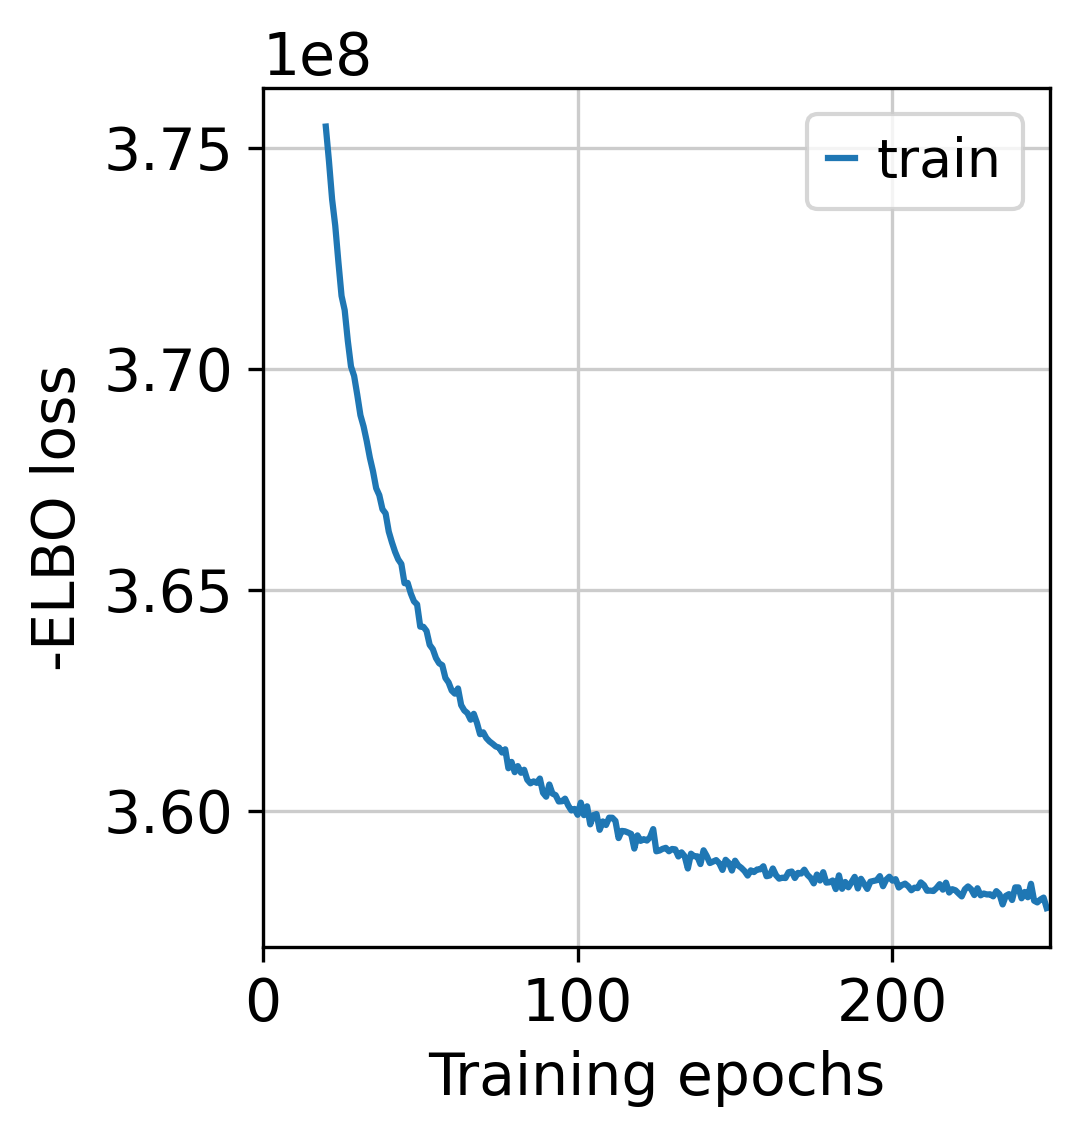

In [18]:
# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [19]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:11<00:00, 85.75it/s]


In [20]:
# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v10_paed_CITE_v4v5/reference_signatures/sc.h5ad'

In [21]:
# load single cell file 
adata_ref = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
adata_ref

AnnData object with n_obs × n_vars = 105816 × 17767
    obs: 'n_genes', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spl

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

In [22]:
# mod.plot_QC()

#read in results of regression model (if notebook is reloaded)
adata_ref = sc.read("/nfs/team205/vk8/scripts/visium/cell2location_v2/results/reference_signatures/sc.h5ad")
adata_vis = sc.read("/nfs/team205/vk8/scripts/visium/cell2location_v2/results/adata_vis_2021-10-01.h5ad")

In [23]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B_activated,B_memory,B_naive,B_plasma,B_propre
AC114498.1,0.942236,0.953877,1.002938,1.010434,0.898272
AL669831.2,0.965379,0.979349,0.980475,0.916847,0.979211
LINC01409,0.101444,0.053697,0.014572,0.114503,0.081034
FAM87B,0.959666,0.926958,0.941255,1.001001,0.968032
FAM41C,0.015117,0.005627,0.008319,0.015253,0.502935


## Cell2location: spatial mapping <a class="anchor" id="cell2location"></a>

In [24]:
#The model and output h5ad can be loaded later like this:

adata_vis_all = sc.read("/nfs/team205/vk8/projects/thymus_atlas/results/Thymus_atlas_v2_Visium_raw_2022-09-07.h5ad")

In [25]:
adata_vis = adata_vis_all[adata_vis_all.obs['Age_group'] != 'fetal'].copy()

In [26]:
for i in adata_vis.uns['spatial'].keys():
    del adata_vis.uns['spatial'][i]['images']['hires']
    del adata_vis.uns['spatial'][i]['images']['hires5K']
    del adata_vis.uns['spatial'][i]['scalefactors']['tissue_hires5K_scalef']
    del adata_vis.uns['spatial'][i]['scalefactors']['tissue_hires_scalef']

In [27]:
adata_vis.uns['spatial']['spaceranger122_count_34880_WSSS_THYst9142086_GRCh38-2020-A']['scalefactors'].keys()

dict_keys(['fiducial_diameter_fullres', 'spot_diameter_fullres', 'tissue_lowres_scalef'])

adata_file = f"{ref_run_name}/sp.h5ad"
adata_ref = sc.read('/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_all/reference_signatures/sc.h5ad')

#mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [28]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()

In [29]:
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
adata_vis

View of AnnData object with n_obs × n_vars = 35764 × 36588
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'L2_dist_Annotation_lv_0_Artifacts', 'Annotation_lv_0', 'L2_dist_Annotation_lv_0_Background', 'L2_dist_Annotation_lv_0_Cortex', 'L2_dist_Annotation_lv_0_Edge', 'L2_dist_Annotation_lv_0_Medulla', 'L2_dist_log10_Annotation_lv_1_HS', 'Annotation_lv_1', 'L2_dist_log10_Annotation_lv_1_Lymph', 'L2_dist_log10_Annotation_lv_1_PVS', 'L2_dist_log10_Annotation_lv_1_Unassigned', 'Annotation_lobules', 'Cortico_Medullar_Axis', 'SampleID', 'L2_dist_Annotation_lv_0_Unassigned', 'Annotation_lobules_0', 'Annotation_lobules_1', 'L2_dist_log10_Annotation_lv_1_Fat', 'Leiden_0_5', 'L2_dist_log10_Annotation_lv_1_Large vessel', 'Sample ', 'Sample_hr', 'SlideID', 'Position', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min

In [30]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
#adata_vis = adata_vis[~adata_vis.obs['SampleID'].isin(['S000001583_U11FO2_D1_st9142089',\
#                                                     'V11J11-100_Z1-THY-FO2_A1_TA11486161',\
                                                 #   'V19D02-039_U09-THY-FO1a_C1_st9518032', \
#                                                    ]), intersect].copy()
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [31]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="SampleID",
                                                categorical_covariate_keys=['SlideID','Spaceranger','section_thickness (um)'],continuous_covariate_keys=['Age(numeric)','n_genes_by_counts'])

Here you need to specify 2 user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`) - for detailed guidance on setting these hyperparameters and their impact see [the flow diagram and the note](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf).

<div class="alert alert-block alert-danger">
<b>Note!</b>
While you can often use the default value of `detection_alpha` hyperparameter, it is useful to  <b>adapt the expected cell abundance `N_cells_per_location` to every tissue</b>. This value can be estimated from paired histology images and as described in the note above. Change the value presented in this tutorial (`N_cells_per_location=30`) to the value observed in your your tissue.
</div>

In [32]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=50,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
) 

mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'SampleID',
│   'labels_key': None,
│   'categorical_covariate_keys': ['SlideID', 'Spaceranger', 'section_thickness (um)'],
│   'continuous_covariate_keys': ['Age(numeric)', 'n_genes_by_counts']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  15   │
│         n_cells          │ 35764 │
│ n_extra_categorical_covs │   3   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 17767 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                       batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['SampleID'] │    TA11486161     │          0          │
│                       │    TA11486162     │          1          │
│                       │    TA11486163     │          2          │
│                       │    TA11486164     │          3          │
│                       │    TA11556492     │          4          │
│                       │    TA11556493     │          5          │
│                       │    TA11556495     │          6          │
│                       │    TA11556496     │          7          │
│                       │ WSSS_THYst9142086 │          8          │
│                       │ WSSS_THYst9142087 │          9          │
│                       │ WSSS_THYst9142088 │         10          │
│                       │ WSSS_THYst9142089 │         11          │
│                       │ WSSS_THYst9518030 │         12          │
│                       │ WSSS_THYst9518032 │         13          │
│                       │ WSSS_THYst9518033 │         14          │
└───────────────────────┴───────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                  extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃           Source Location           ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│        adata.obs['SlideID']         │ V11J11-099 │          0          │
│                                     │ V11J11-100 │          1          │
│                                     │ V11J11-102 │          2          │
│                                     │ V19D02-039 │          3          │
│                                     │ V19S16-069 │          4          │
│                                     │            │                     │
│      adata.obs['Spaceranger']       │   1.2.2    │          0          │
│                                     │   1.3.0    │          1          │
│                                     │            │                     │
│ adata.obs['section_thickness (um)'] │    7.0     │          0          │
│                                     │    10.0    │          1          │
│                                     │            │                     │
└─────────────────────────────────────┴────────────┴─────────────────────┘

   extra_continuous_covs State    
             Registry             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   adata.obs['Age(numeric)']    │
│ adata.obs['n_genes_by_counts'] │
└────────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2/30000:   0%|                                                                                                                                                                                    | 1/30000 [00:00<2:56:38,  2.83it/s, v_num=1, elbo_train=3.26e+8]

/nfs/team205/vk8/miniconda/envs/cell2loc_new/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 30000/30000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [2:31:53<00:00,  3.28it/s, v_num=1, elbo_train=1.34e+8]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [2:31:53<00:00,  3.29it/s, v_num=1, elbo_train=1.34e+8]


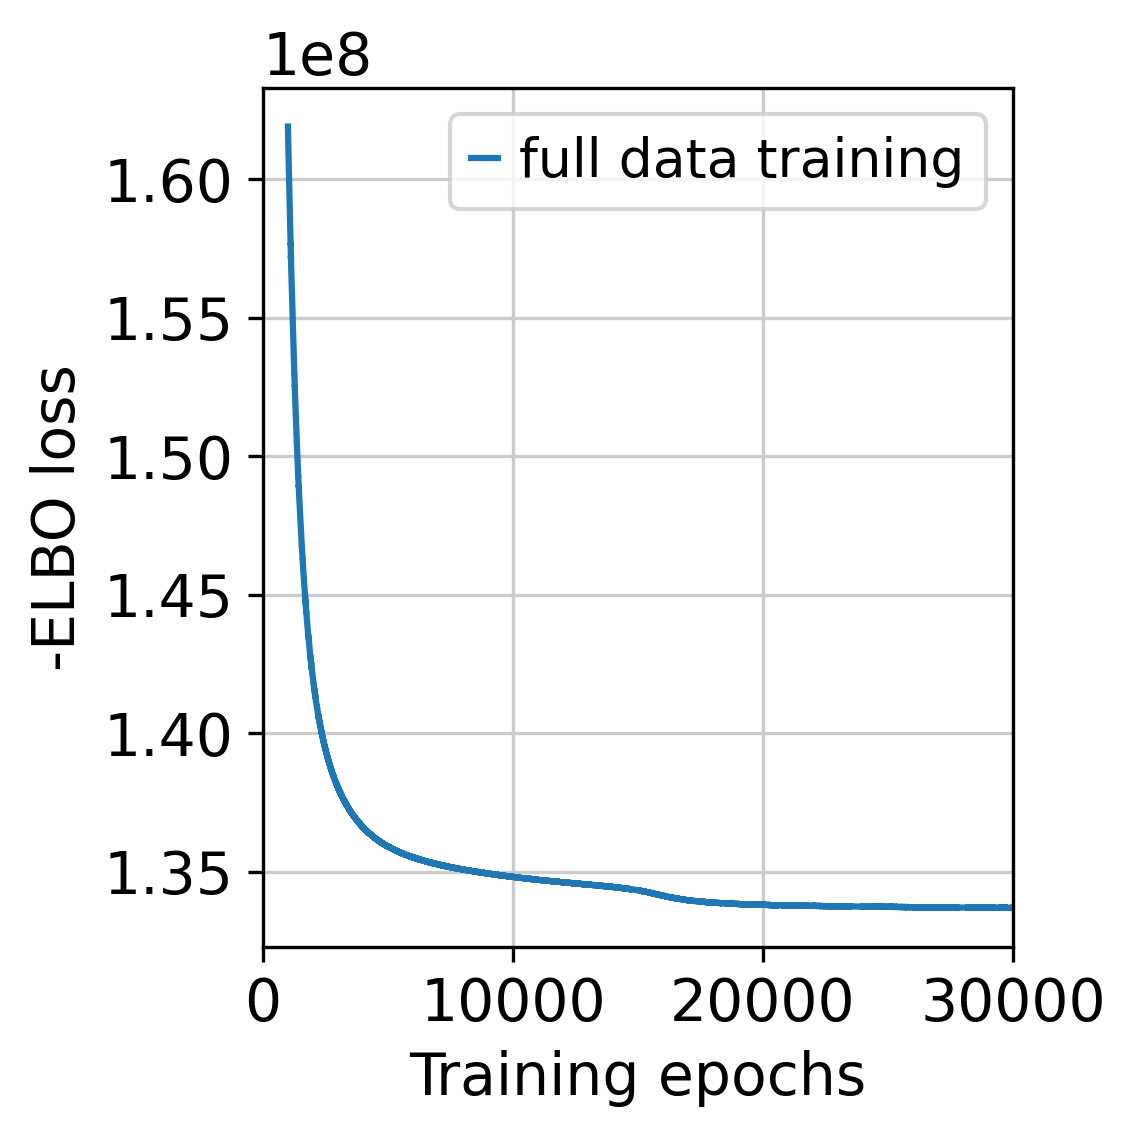

In [33]:
mod.train(max_epochs=30000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [37]:
run_name

'/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v10_paed_CITE_v4v5/cell2location_map'

In [39]:
# Save model and visium data 
os.mkdir(run_name)
adata_file = f"{run_name}/adat2a_vis.h5ad"
adata_vis.write(adata_file)
mod.save(f"{run_name}", overwrite=True)

# consider restarting kernel before this state 


In [3]:
# load model and visium data 
adata_vis = sc.read_h5ad(f"{run_name}/adata_vis.h5ad")
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/nfs/team205/vk8/projects/thymus_atlas/results/thymus_atlas_v2_anno_v10_paed_CITE_v4v5/cell2location_map/adata_vis.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# load single cell file 
adata_ref = sc.read_h5ad(f"{ref_run_name}/sc.h5ad")
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
# expected_dict = mod.module.model.compute_expected_per_cell_type(
#     adata_vis.uns['mod']['post_sample_q05'], mod.adata_manager
# )

# # Add to anndata layers
# for i, n in enumerate(mod.factor_names_):
#     adata_vis.layers[n] = expected_dict['mu'][i]

In [ ]:
# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file